In [1]:
%%time
import yfinance as yf
import pandas as pd
from datetime import datetime
import os
from time import sleep, time
from dateutil.relativedelta import relativedelta
import sklearn as sk
from sklearn.preprocessing import StandardScaler

import numpy as np

CPU times: user 321 ms, sys: 56 ms, total: 377 ms
Wall time: 536 ms


In [2]:
# Functions to maintain and call the S&P 500 from a current date
# Author Michael Djaballah
# Time last edited: 5:56 PM June 1, 2020
# Last edited by: Michael Djaballah

# Takes no input
# Output is newly saved CSV's containing the current makeup of the S&P 500 
# and its historical additions and removals
# data_path is changeable depending on desired save location
def get_snp_store(data_path='data/'):
    curr_raw = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    
    curr = curr_raw[0]
    hist = curr_raw[1]
    
    new_hist = pd.DataFrame(hist['Date'])
    new_hist['Added'] = hist['Added', 'Ticker']
    new_hist['Removed'] = hist['Removed', 'Ticker']
    
    os.makedirs(data_path, exist_ok=True)
    
    curr.to_csv(data_path + 'snp_current.csv', index=False)
    new_hist.to_csv(data_path + 'snp_hist.csv', index=False)
    return None


# Input: a date in string form with its corresponding format:
# Ex: 'January 1, 2020', '%B %d, %Y'
# Output: a list containing the S&P 500 at the input date
def build_snp(date, date_format, data_path='data/'):
    curr = pd.read_csv(data_path + 'snp_current.csv')
    hist = pd.read_csv(data_path + 'snp_hist.csv')
    
    start_date = datetime.strptime(date, date_format)
    
    snp_set = set(curr['Symbol'])
    
    for i in range(len(hist)):
        temp_date = datetime.strptime(hist.iloc[i]['Date'], date_format)
        if temp_date < start_date:
            break

        tb_removed = hist.iloc[i]['Added']
        tb_added = hist.iloc[i]['Removed']

        if tb_removed in snp_set:
            snp_set.remove(tb_removed)
        if not type(tb_added) == float:
            snp_set.add(tb_added)
    
    return list(snp_set)

# Included to build returns for a SPY comparison
# Input is a portfolio (ticker:df dictionary), the tickers desired for returns, and the date of returns
# Output is a list of floats that are returns
def build_returns(portfolio, tickers, date):
    returns = []
    for ticker in tickers:
        temp_ticker_dict = portfolio[ticker].set_index('Date').loc[date]
        returns.append((temp_ticker_dict['Close'] - temp_ticker_dict['Open'])/temp_ticker_dict['Open'])
    return returns

In [3]:
class Portfolio:
    def __init__(self, tickers, hist_depth=None, train_depth=None, features=[], 
                 data_path = 'data/', prefix = 'monthly/', interval = '1mo', 
                 data_start = '2001-01-01', target='Close'):
        self.portfolio = {}
        self.tickers = tickers
        self.features = features
        self.target = target
        
        self.hist_depth = hist_depth
        self.train_depth = train_depth
        
        self.interval = interval
        self.data_start = data_start
        
        self.data_path = data_path
        self.prefix = prefix
        
        self.results = []
        
        self.blacklist = set()
        
        self.portfolio = self.build_portfolio()
        self.tickers = list(self.portfolio.keys())
        self.columns = self.build_columns()
        
    
    def get_data(self, return_bad_tickers=False):
        bad_tickers = []

        os.makedirs(self.data_path + self.prefix, exist_ok=True)

        curr_tickers = set(os.listdir(self.data_path + self.prefix))

        for ticker in self.tickers:
            ticker_label = ticker + '.csv'

            if ticker_label not in curr_tickers:
                temp_ticker = yf.Ticker(ticker)
                temp_hist = temp_ticker.history(start=self.data_start, interval=self.interval)
                temp_hist.dropna(axis=0, inplace=True)
                temp_hist.to_csv(self.data_path + self.prefix + ticker_label)

                if len(temp_hist) < 90:
                    bad_tickers.append((ticker, len(temp_hist)))
                sleep(.5)

        if return_bad_tickers:
            return bad_tickers

        return None
    
    
    def build_columns(self):
        columns = []
        for i in range(self.hist_depth):
            for feature in self.features:
                columns.append(feature + ' ' + str(i + 1))
        return columns
    
    
    def check_ticker(self, ticker, offset):
        ticker_df = pd.read_csv(self.data_path + self.prefix + ticker + '.csv')
        if len(ticker_df) >= offset:
            return ticker_df
        return False
    
    
    def build_portfolio(self):
        offset = self.train_depth + self.hist_depth + 60 + 12

        self.get_data()

        ticker_dict = {}

        for ticker in self.tickers:
            if ticker not in self.blacklist:
                ticker_df = self.check_ticker(ticker, offset)
                if type(ticker_df) != bool:
                    ticker_df.set_index('Date', inplace=True)
                    ticker_df.index = pd.to_datetime(ticker_df.index)
                    ticker_dict[ticker] = ticker_df

        return ticker_dict
    
    
    def build_returns(self, symbols, date):
        returns = []
        for ticker in symbols:
            temp_ticker_dict = self.portfolio[ticker].set_index('Date').loc[date]
            returns.append((temp_ticker_dict['Close'] - temp_ticker_dict['Open'])/temp_ticker_dict['Open'])
        return returns
    
    
    def build_scaled_df(self, dataframe):
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(dataframe)
        scaled_dataframe = pd.DataFrame(scaled_array, columns=dataframe.columns)
        return scaled_dataframe
    
    
    def check_date(self, ticker, date):
        dates = set(self.portfolio[ticker]['Date'])
        return date in dates
    
    
    def build_machine(self, model, date, n=15):
        train_df = self.build_train_df(date)
        scaled_train_df = self.build_scaled_df(train_df)

        scaled_train_df.dropna(axis=0, inplace=True)

        X = scaled_train_df.values[:,:-1]
        y = scaled_train_df.values[:, -1]
        model.fit(X, y)

        test_df, symbols = self.build_test_df(date)
        scaled_test_df = self.build_scaled_df(test_df)
        X_test = scaled_test_df.values

        predicted_returns = list(model.predict(X))

        returns_dict = {}

        for i in range(len(symbols)):
            returns_dict[symbols[i]] = predicted_returns[i]

        top = sorted(returns_dict.items(), key=lambda x: x[1])[::-1][:n]
        return [x[0] for x in top]
    
    
    def backtest(self, model, start_date, end_date):
        months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))

        overall_returns = []
        specific_returns = []
        for month in months:
            start_time = time()
            for ticker in self.tickers:
                if ticker not in self.blacklist:
                    if not self.check_date(ticker, month):
                        self.blacklist.add(ticker)
            symbols = self.build_machine(model, month)
            ticker_returns = self.build_returns(symbols, month)
            overall_returns.append(sum(ticker_returns)/len(ticker_returns))
            print(month, round(sum(ticker_returns)/len(ticker_returns), 6), round(time()-start_time, 2))
            
            specific_returns_dict = {}
            for i in range(len(ticker_returns)):
                specific_returns_dict[symbols[i]] = ticker_returns[i]
            specific_returns.append(specific_returns_dict)
            
        self.results = specific_returns
        return overall_returns
    
    
#     def build_feature_vector(self, ticker, date, keep_pred=True):
#         ticker_df = self.portfolio[ticker]

#         start_date_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=self.hist_depth)
#         start_date = start_date_dt.strftime('%Y-%m-%d')

#         feature_df = ticker_df.set_index('Date')[start_date:date].reset_index(drop=True)[self.features]
        
#         new_df_dict = {}

#         for i in range(len(feature_df)):
#             for col in feature_df.columns:
#                 if i < len(feature_df) - 1:
#                     new_df_dict[col + ' ' + str(i + 1)] = [feature_df[col].iloc[i]]
#                 elif col == self.target:
#                     if keep_pred:
#                         new_df_dict['Target'] = [feature_df[col].iloc[i]]

#         new_df = pd.DataFrame.from_dict(new_df_dict)
        
#         if len(new_df) == 0:
#             self.blacklist.add(ticker)
#             return -1

#         if keep_pred:
#             new_df = new_df[[col for col in list(new_df.columns) if col not in {'Target'}] + ['Target']]
        
#         return new_df
    
    
#     def build_train_df(self, date):    
#         vector_list = []
#         for ticker in self.tickers:
#             if ticker not in self.blacklist:
#                 for i in range(self.train_depth):
#                     train_start_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=(1+i))
#                     train_start = train_start_dt.strftime('%Y-%m-%d')
#                     vector = self.build_feature_vector(ticker, train_start)
                    
#                     if type(vector) != int:
#                         vector_list.append(vector)
        
#         start_time = time()
#         feature_df = pd.concat(vector_list)
#         print(time() - start_time)
#         return feature_df.reset_index(drop=True)
    
    
#     def build_test_df(self, date):
#         vector_list = []
#         index_list = []
#         for ticker in self.tickers:
#             if ticker not in self.blacklist:
#                 vector = self.build_feature_vector(ticker, date, keep_pred=False)
#                 if type(vector) != int:
#                     vector_list.append(vector)
#                     index_list.append(ticker)

#         start_time = time()
#         test_df = pd.concat(vector_list)
#         print(time() - start_time)
#         return test_df.reset_index(drop=True), index_list
    
    
    def build_feature_vector(self, ticker, date, keep_pred=True):
        ticker_df = self.portfolio[ticker]

        start_date_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=self.hist_depth)
        start_date = start_date_dt.strftime('%Y-%m-%d')

        feature_df = ticker_df.loc[start_date:date][self.features]
        
        new_df_dict = {}

        for i in range(len(feature_df)):
            for col in feature_df.columns:
                if i < len(feature_df) - 1:
                    new_df_dict[col + ' ' + str(i + 1)] = [feature_df[col].iloc[i]]
                elif col == self.target:
                    if keep_pred:
                        new_df_dict['Target'] = [feature_df[col].iloc[i]]

        new_df = pd.DataFrame.from_dict(new_df_dict)
        
        if len(new_df) == 0:
            self.blacklist.add(ticker)
            return -1

        if keep_pred:
            new_df = new_df[[col for col in list(new_df.columns) if col not in {'Target'}] + ['Target']]
        
        return new_df
    
    
    def build_train_df(self, date):    
        vector_list = []
        for ticker in self.tickers:
            if ticker not in self.blacklist:
                for i in range(self.train_depth):
                    train_start_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=(1+i))
                    train_start = train_start_dt.strftime('%Y-%m-%d')
                    vector = self.build_feature_vector(ticker, train_start)
                    
                    if type(vector) != int:
                        vector_list.append(vector)
        
#         start_time = time()
        feature_df = pd.concat(vector_list)
#         print(time() - start_time)
        return feature_df.reset_index(drop=True)
    
    
    def build_test_df(self, date):
        vector_list = []
        index_list = []
        for ticker in self.tickers:
            if ticker not in self.blacklist:
                vector = self.build_feature_vector(ticker, date, keep_pred=False)
                if type(vector) != int:
                    vector_list.append(vector)
                    index_list.append(ticker)

#         start_time = time()
        test_df = pd.concat(vector_list)
#         print(time() - start_time)
        return test_df.reset_index(drop=True), index_list
    
    
    def build_train(self, date):
        X = np.zeros((self.train_depth * len(self.portfolio), self.hist_depth * len(self.features)))
        y = np.zeros(self.train_depth * len(self.portfolio))
        j = 0
        for ticker in self.portfolio:
            ticker_df = self.portfolio[ticker]
            date_i = ticker_df.index.get_loc(date)
            for i in range(1, self.train_depth + 1):
                start = date_i - i - self.hist_depth
                end = date_i - i 
                X[j] = ticker_df.iloc[start:end][self.features].values.flatten()
                y[j] = ticker_df.iloc[date_i - i + 1][self.target]
                j += 1
        return X, y
    
    
    def build_test(self, date):
        X = np.zeros((len(self.portfolio), self.hist_depth * len(self.features)))
        tickers = list(self.portfolio.keys())
        j = 0
        for ticker in tickers:
            ticker_df = self.portfolio[ticker]
            date_i = ticker_df.index.get_loc(date)
            start = date_i - self.hist_depth
            end = date_i
            X[j] = ticker_df.iloc[start:end][self.features].values.flatten()
            j += 1
        return X, tickers

In [12]:
%%time
# CPU times: user 748 ms, sys: 0 ns, total: 748 ms
# Wall time: 747 ms
start_date = '2015-01-01'
end_date = '2019-12-01'
universe = build_snp('January 1, 2015', '%B %d, %Y')

hist_depth = 36
train_depth = 36
features = ['Close', 'Volume']
target = 'Close'

port = Portfolio(
    universe, 
    hist_depth=hist_depth, 
    train_depth=train_depth, 
    features = features
)

CPU times: user 799 ms, sys: 8 ms, total: 807 ms
Wall time: 807 ms


In [38]:
%%time
opt_times_t = []
nai_times_t = []
sizes = [1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128]

for i in sizes:
    hist_depth = 6
    train_depth = i

    port = Portfolio(
        universe, 
        hist_depth=hist_depth, 
        train_depth=train_depth, 
        features = features
    )
    t1 = time()
    nan = port.build_train(start_date)
    t2 = time()
    nan = port.build_train_df(start_date)
    t3 = time()
    opt_times_t.append(t2-t1)
    nai_times_t.append(t3-t2)

    
opt_times_h = []
nai_times_h = []
for i in sizes:
    hist_depth = i
    train_depth = 6

    port = Portfolio(
        universe, 
        hist_depth=hist_depth, 
        train_depth=train_depth, 
        features = features
    )
    t1 = time()
    nan = port.build_train(start_date)
    t2 = time()
    nan = port.build_train_df(start_date)
    t3 = time()
    opt_times_h.append(t2-t1)
    nai_times_h.append(t3-t2)

CPU times: user 13min 46s, sys: 620 ms, total: 13min 47s
Wall time: 13min 47s


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
data = pd.DataFrame()
data['Nai Train'] = nai_times_t
data['Opt Train'] = opt_times_t
data['Nai Hist'] = nai_times_h
data['Opt Hist'] = opt_times_h
data.index = sizes

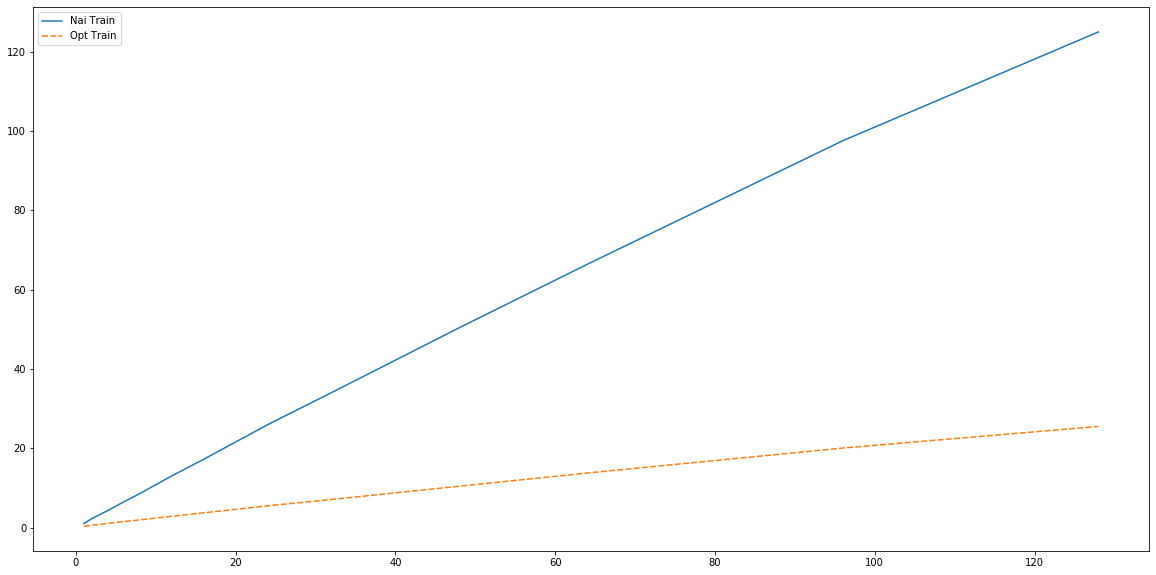

In [45]:
plt.figure(figsize=(20,10))
sns.lineplot(data=data[['Nai Train', 'Opt Train']])

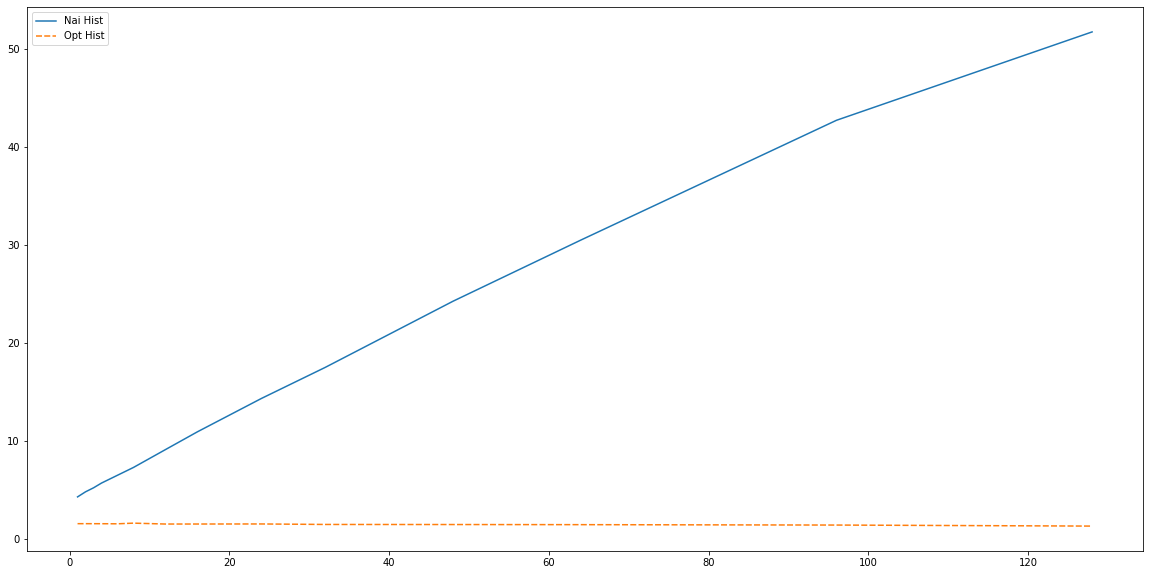

In [46]:
plt.figure(figsize=(20,10))
sns.lineplot(data=data[['Nai Hist', 'Opt Hist']])

In [48]:
import statsmodels.api as sm 

In [84]:
y = data['Opt Hist'].values
X = data.index.values

reg = sm.OLS(y, X).fit()
print(reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.366
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              7.513
Date:                Mon, 02 Nov 2020   Prob (F-statistic):                      0.0168
Time:                        17:31:03   Log-Likelihood:                         -22.041
No. Observations:                  14   AIC:                                      46.08
Df Residuals:                      13   BIC:                                      46.72
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [83]:
reg.predict(500)

array([103.38416734])

In [13]:
%%time
# CPU times: user 1.43 s, sys: 0 ns, total: 1.43 s
# Wall time: 1.43 s
nan = port.build_train(start_date)
# nan = port.build_test(start_date)

CPU times: user 7.77 s, sys: 8 ms, total: 7.78 s
Wall time: 7.78 s


In [14]:
%%time
# CPU times: user 6.23 s, sys: 0 ns, total: 6.23 s
# Wall time: 6.23 s
nan = port.build_train_df(start_date)
# nan = port.build_test_df(start_date)

CPU times: user 1min 55s, sys: 112 ms, total: 1min 55s
Wall time: 1min 55s


In [11]:
%%time
# CPU times: user 1.14 s, sys: 13 µs, total: 1.14 s
# Wall time: 1.14 s
date = '2015-01-01'
X = np.zeros((train_depth * len(port.portfolio), hist_depth * len(features)))
y = np.zeros(train_depth * len(port.portfolio))
j = 0
for ticker in port.portfolio:
    ticker_df = port.portfolio[ticker]
    date_i = ticker_df.index.get_loc(date)
    for i in range(1, train_depth + 1):
        start = date_i - i - hist_depth
        end = date_i - i 
        X[j] = ticker_df.iloc[start:end][features].values.flatten()
        y[j] = ticker_df.iloc[date_i - i + 1][target]
        j += 1

CPU times: user 1.41 s, sys: 3.96 ms, total: 1.41 s
Wall time: 1.41 s


In [168]:
X_t = np.zeros((len(port.portfolio), hist_depth * len(features)))
j = 0
for ticker in port.portfolio:
    ticker_df = port.portfolio[ticker]
    date_i = ticker_df.index.get_loc(date)
    start = date_i - hist_depth
    end = date_i
    X_t[j] = ticker_df.iloc[start:end][features].values.flatten()
    j += 1

In [169]:
port.build_train('2015-01-01')

(array([[7.51600e+01, 3.34308e+07, 8.12900e+01, ..., 7.22552e+07,
         8.26100e+01, 3.25797e+07],
        [7.45300e+01, 3.54105e+07, 7.51600e+01, ..., 3.37439e+07,
         8.05800e+01, 7.22552e+07],
        [6.92200e+01, 5.03555e+07, 7.45300e+01, ..., 4.35210e+07,
         8.30900e+01, 3.37439e+07],
        ...,
        [5.02500e+01, 2.98535e+07, 5.02400e+01, ..., 2.73774e+07,
         5.28800e+01, 3.28400e+07],
        [4.87100e+01, 4.75973e+07, 5.02500e+01, ..., 3.96465e+07,
         5.13500e+01, 2.73774e+07],
        [4.91100e+01, 4.72723e+07, 4.87100e+01, ..., 2.98092e+07,
         4.90700e+01, 3.96465e+07]]),
 array([81.66, 81.11, 82.61, ..., 60.46, 54.44, 52.88]))

In [170]:
port.build_test('2015-01-01')

(array([[8.129000e+01, 4.352100e+07, 8.309000e+01, ..., 3.257970e+07,
         8.111000e+01, 4.051990e+07],
        [6.425000e+01, 3.829480e+07, 6.490000e+01, ..., 4.029390e+07,
         7.264000e+01, 4.017710e+07],
        [4.051000e+01, 3.179900e+07, 4.100000e+01, ..., 3.434450e+07,
         4.462000e+01, 5.362590e+07],
        ...,
        [1.459400e+02, 2.372420e+07, 1.556600e+02, ..., 2.539530e+07,
         1.653100e+02, 2.629690e+07],
        [2.101000e+01, 5.669110e+08, 2.071000e+01, ..., 5.372423e+08,
         2.061000e+01, 9.016472e+08],
        [5.135000e+01, 2.737740e+07, 5.288000e+01, ..., 3.060180e+07,
         6.024000e+01, 3.093200e+07]]),
 dict_keys(['EXPE', 'MAR', 'WM', 'FIS', 'PRU', 'ETFC', 'NDAQ', 'XEL', 'AIG', 'AEE', 'ROP', 'WELL', 'LH', 'DD', 'EXC', 'SJM', 'PCAR', 'WFC', 'MYL', 'AME', 'CRM', 'AMAT', 'TROW', 'MLM', 'VRSN', 'AXP', 'BAC', 'SBUX', 'FOSL', 'TDC', 'APH', 'DGX', 'NBL', 'MCD', 'TGT', 'GT', 'GM', 'PDCO', 'CL', 'JCI', 'MDLZ', 'ALLE', 'KMI', 'TPR', 'RIG', 'FE

In [143]:
port.portfolio['MAR'].loc['2015-01-01']

Open                  72.93
High                  74.11
Low                   68.80
Close                 69.35
Volume          41033200.00
Dividends              0.00
Stock Splits           0.00
Name: 2015-01-01 00:00:00, dtype: float64

In [144]:
len(y)

2120

In [145]:
%%time
oy = port.build_train_df('2015-01-01').values[:, -1]
len(oy)

1.0897955894470215
CPU times: user 4.81 s, sys: 3.84 ms, total: 4.82 s
Wall time: 4.82 s


2120

In [151]:
oy

array([81.11, 82.61, 80.58, ..., 54.44, 52.88, 51.35])

In [121]:
%%time
vec = port.build_feature_vector('AAPL', '2015-06-01')

CPU times: user 4.49 ms, sys: 12 µs, total: 4.51 ms
Wall time: 4.29 ms


In [122]:
vec.values

array([[2.6730000e+01, 5.2210536e+09, 2.9310000e+01, 4.5461408e+09,
        2.8500000e+01, 4.5545684e+09, 2.8660000e+01, 3.9845420e+09,
        2.9840000e+01, 3.8166084e+09, 2.8850000e+01]])

In [123]:
aapl[features].loc['2015-01-01':'2015-05-01'].values.flatten()
# aapl[features].loc['2015-01-01':'2015-05-01']

array([2.6730000e+01, 5.2210536e+09, 2.9310000e+01, 4.5461408e+09,
       2.8500000e+01, 4.5545684e+09, 2.8660000e+01, 3.9845420e+09,
       2.9840000e+01, 3.8166084e+09])

In [125]:
aapl = port.portfolio['AAPL']
aapl.loc['2016-01-01':'2016-04-01']

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-01,23.81,24.56,21.44,22.58,5.087392e+09,0.0,0.0
2016-02-01,22.38,22.94,21.48,22.43,3.243450e+09,0.0,0.0
2016-03-01,22.78,25.76,22.73,25.42,2.984198e+09,0.0,0.0
2016-04-01,25.38,26.22,21.58,21.87,3.489535e+09,0.0,0.0


In [126]:
n = len(port.portfolio) * train_depth
n

2120

In [127]:
%%time
for i in range(n):
    new_vec = aapl[features].loc['2015-01-01':'2015-05-01'].values.flatten()

CPU times: user 1.44 s, sys: 36.3 ms, total: 1.48 s
Wall time: 1.44 s


In [128]:
%%time
for i in range(n):
    port.build_feature_vector('AAPL', '2015-01-01')

CPU times: user 3.61 s, sys: 3.74 ms, total: 3.61 s
Wall time: 3.61 s


In [132]:
%%time
port.build_train_df('2015-01-01').values[:, :-1]

1.1652109622955322
CPU times: user 4.81 s, sys: 23.3 ms, total: 4.84 s
Wall time: 4.84 s


array([[7.51600e+01, 3.34308e+07, 8.12900e+01, ..., 7.22552e+07,
        8.26100e+01, 3.25797e+07],
       [7.45300e+01, 3.54105e+07, 7.51600e+01, ..., 3.37439e+07,
        8.05800e+01, 7.22552e+07],
       [6.92200e+01, 5.03555e+07, 7.45300e+01, ..., 4.35210e+07,
        8.30900e+01, 3.37439e+07],
       ...,
       [5.02500e+01, 2.98535e+07, 5.02400e+01, ..., 2.73774e+07,
        5.28800e+01, 3.28400e+07],
       [4.87100e+01, 4.75973e+07, 5.02500e+01, ..., 3.96465e+07,
        5.13500e+01, 2.73774e+07],
       [4.91100e+01, 4.72723e+07, 4.87100e+01, ..., 2.98092e+07,
        4.90700e+01, 3.96465e+07]])

In [76]:
%%time
# port.build_test_df('2015-01-01')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [21]:
port['AAPL']

TypeError: 'Portfolio' object is not subscriptable